<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Larissa_Santesso/entrega_01/CNN_T5_wandb_exp001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wandb

In [ ]:
!pip install wandb -qqq

In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Currently logged in as: larissa_santesso. Use `wandb login --relogin` to force relogin


True

In [ ]:
config_wandb={
        "learning_rate": 3e-4,
        "batch_size": 25,
        "architecture": "CNN + T5-small",
        "dataset": "MS-COCO 23k",
        "epochs": 50,
        "eval_epochs": 1,
        "max_seq_length": 32,
        "decoder_pretrained_model": "google/t5-efficient-small-dm768",
        "path_save_model":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/modelos/model_CNN_T5_wandb_exp001.pt",
        "path_save_checkpoints":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/checkpoints/",
        "checkpoint_folder_name": "checkpoint_CNN_T5_001.tar"

}


run = "001"

run_id = None
# run_id = '1aku8hkl'

# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
from transformers import T5ForConditionalGeneration, T5Tokenizer
from matplotlib import pyplot as plt
import math
import random
import numpy as np
import h5py, json
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import collections
import itertools
import functools
from tqdm.notebook import tqdm

from sacrebleu.metrics import BLEU 

In [ ]:
# Check which GPU we are using
!nvidia-smi

Wed Jun 29 12:31:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Dataset: MS-COCO

## Download do dataset reduzido

In [ ]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-29 11:51:45--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4624222304 (4.3G) [application/octet-stream]
Saving to: ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’

TRAIN_IMAGES_coco_5 100%[===================>]   4.31G   181MB/s    in 27s     

2022-06-29 11:52:12 (163 MB/s) - ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’ saved [4624222304/4624222304]

--2022-06-29 11:52:12--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... 

In [ ]:
ls

gdrive/                                 TRAIN_IMAGES_coco_5_cap_per_img.hdf5
sample_data/                            VAL_CAPTIONS_coco_5_cap_per_img.json
TEST_IMAGES_coco_5_cap_per_img.hdf5     VAL_IMAGES_coco_5_cap_per_img.hdf5
TRAIN_CAPTIONS_coco_5_cap_per_img.json


## Download do dataset completo

Em construção

## Construindo CocoDataset `class`


In [ ]:
class CocoDataset():
    def __init__(self, transform=None, mode_dataset = 'TRAIN'):
        
        self.transform = transform

        self.imgs = h5py.File(str(mode_dataset)+'_IMAGES_coco_5_cap_per_img.hdf5', 'r')
        self.imgs = self.imgs['images']
        self.captions = json.load(open(str(mode_dataset)+'_CAPTIONS_coco_5_cap_per_img.json'))

        assert len(self.imgs) == len(self.captions)

    def __len__(self):  
        return len(self.captions)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        caption = self.captions[idx]

        #if self.random_caption==True:
        #    caption = random.choice(caption) 
        
        if self.transform is not None:
            img = self.transform(np.transpose(np.copy(img), (1, 2, 0)))

        return img, caption

In [ ]:
transform_img = transforms.Compose([
    transforms.ToTensor(),         # convert the PIL Image to a tensor
    transforms.Resize(size = (224,224)),
    #transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

tokenizer = T5Tokenizer.from_pretrained(config_wandb["decoder_pretrained_model"])

train_dataset = CocoDataset(transform = transform_img)
val_dataset = CocoDataset(transform = transform_img, mode_dataset='VAL')
#test_dataset = CocoDataset(tokenizer = tokenizer, transform = transform_img, mode_dataset='TEST') ## não tem captions!!!

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# Modelo


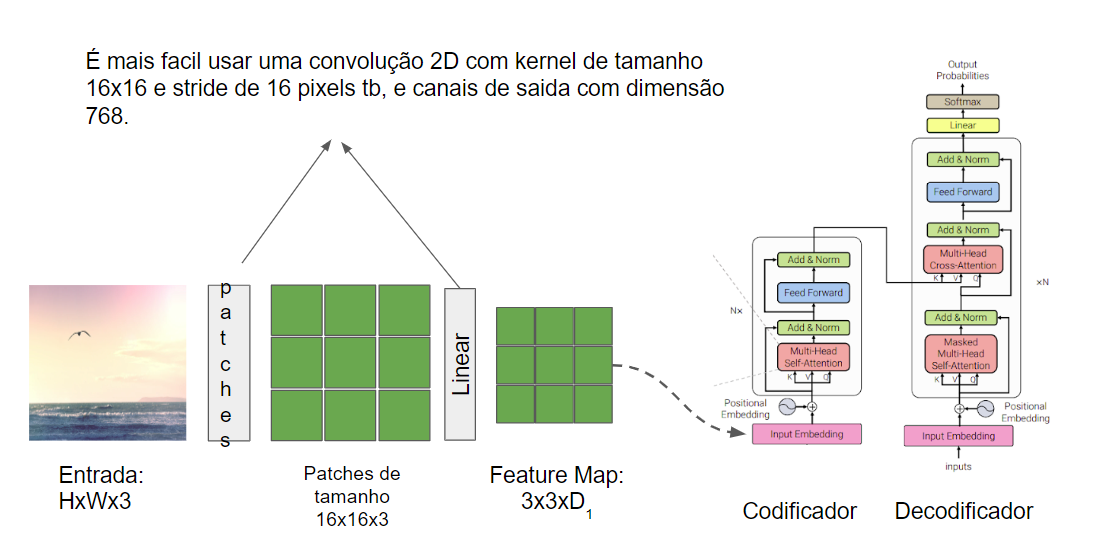

## Decoder T5


https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration

https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/output#transformers.modeling_outputs.Seq2SeqLMOutput

https://huggingface.co/blog/how-to-generate

In [ ]:
def collate_custom(batch):
    """
    Input any (selected randomly) caption sample for every image. Useful for training.
    """
    
    imgs = [r[0] for r in batch]
    texts = [r[1] for r in batch] # all captions (5) of each image -- purpose: calculus of NLP metrics
    text = [random.choice(r[1]) for r in batch] # one random caption of each image -- purpose: for training

    batch_tokens = tokenizer.batch_encode_plus(text, return_tensors="pt", max_length=config_wandb["max_seq_length"], padding='max_length', truncation=True)

    return (
        torch.stack(imgs), 
        batch_tokens["input_ids"], 
        texts,
    )

In [ ]:
class CNNT5Model(torch.nn.Module):

    def __init__(self, tokenizer, pretrained_model, max_seq_length=32, img_size = (224,224), patches_size=16, n_channels = 3, input_dimTransformer = 768):
        """
        Implements the Self-attention, decoder-only."

        Args:
            vocab_size (int): Size of the input vocabulary.
            max_seq_length (int): Size of the sequence to consider as context for prediction.
            dim (int): Dimension of the embedding layer for each word in the context.
            n_layers (int): number of self-attention layers.
            pad_token_id (int): id of the pad token that will be ignored in the attention.
        """
        super(CNNT5Model, self).__init__()

        self.max_seq_length = max_seq_length
        self.pad_token_id = tokenizer.pad_token_id
        self.eos_token_id = tokenizer.eos_token_id
        
        self.img_size = img_size
        self.n_channels = n_channels
        self.embed_size = input_dimTransformer

        # Initializing CNN for creation of patches
        self.cnn_pacthes = nn.Conv2d(self.n_channels, self.embed_size, kernel_size=(patches_size, patches_size), stride=(patches_size, patches_size))
        self.transformer = T5ForConditionalGeneration.from_pretrained(pretrained_model)
        self.transformer.config.eos_token_id = tokenizer.eos_token_id
        self.transformer.config.pad_token_id = tokenizer.pad_token_id
        self.decoder_start_token_id = self.transformer.config.decoder_start_token_id
        # Embedding of the pactches
        self.embeddings_P = nn.Embedding((img_size[0]//patches_size)*(img_size[1]//patches_size), self.embed_size)
        #print(self.embeddings_P.weight.shape)
        self.dropout = nn.Dropout(p=0.1)

    def creating_patches_from_images(self, inputs):
        out_patches = self.cnn_pacthes(inputs).permute(0, 2, 3, 1) #.view(B,input_dimTransformer,H//patches_size*W//patches_size)
        out_patches  = out_patches .reshape(out_patches.shape[0], -1, self.embed_size)
        out_patches+=self.embeddings_P.weight
        #out_patches = self.dropout(out_patches)

        return out_patches

    def forward(self, images = None, targets = None, decoder_ids = None):

        out = self.creating_patches_from_images(images)
        
        if decoder_ids is not None:
            out = self.transformer(inputs_embeds=out, decoder_input_ids=decoder_ids)
        
        # training
        else:
            out = self.transformer(inputs_embeds=out, labels=targets)
            
        return out

In [ ]:
model = CNNT5Model(tokenizer, config_wandb["decoder_pretrained_model"])

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Número de parâmetros do modelo: {num_params}')

Número de parâmetros do modelo: 91500800


# Treinamento

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

['A dog is sitting on a bed with a dog. a dog is sitting on a', 'A man is sitting on a bench with a dog. a dog is sitting on the back of', 'A large airplane is sitting on the runway. a large bird is sitting on top of a tree.', 'A cat sitting on top of a laptop computer. a cat is sitting on top of a laptop.', 'A man is riding a horse in a field.', 'A man riding a horse in a field.', 'A man is riding a horse in a field. a man is riding a horse', 'A man is riding a horse in a field. a dog is laying on the back of a', 'A man is riding a horse in a field.', 'A bird is sitting on a branch of a tree. a giraffe standing in the grass.', 'A dog is laying on a bed with a dog. a dog is laying on the ground.', 'A large white bird sitting on top of a tree branch. a large white bird is sitting on top of a', 'A dog is laying on a bed with a dog.', 'A cat is sitting on top of a laptop.', 'A cat sitting on top of a laptop computer. a cat is sitting on top of a laptop.', 'A cat sitting on top of a laptop

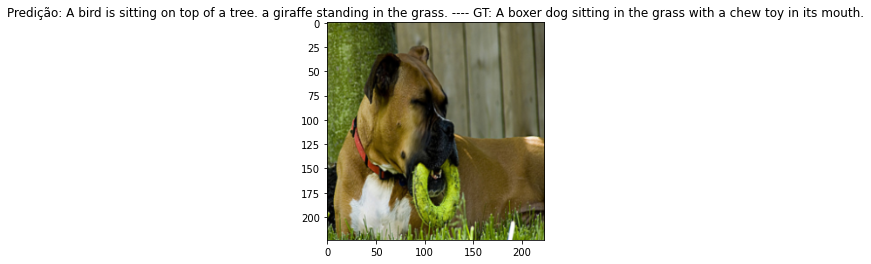

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Época: 0/49 Train Loss: 2.990998  Valid Loss: 9.769713 / Train BLEU: 2.3211724514474787 Valid BLEU: 6.53231979140349


  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

['A cat is sitting on a table with a stuffed animal.', 'A cat is sitting on a table with a cat.', 'A man riding a horse in a field with a dog. a close up of', 'A cat is sitting on a table with a cat. a cat is', 'A man is riding a horse in a field.', 'A man riding a horse in a field with a dog.', 'A man is riding a horse in a field. a man is riding a horse', 'A man is riding a horse in a field. a man is riding', 'A man is riding a horse in a field.', 'A giraffe is standing in the grass. a zebra standing in a field with a', 'A giraffe is standing in the grass. a close up of a giraffe standing', 'A man is riding a horse in a field. a close up of a', 'A dog is sitting on a bench next to a tree.', 'A cat is sitting on a table with a hot dog.', 'A cat is sitting on a table with a cat.', 'A cat is sitting on a table with a cat.', 'A cat is sitting on a laptop computer. a cat is sitting on a table with', 'A man is sitting on a bench with a dog.', 'A cat is sitting on a table with a cat. a cat 

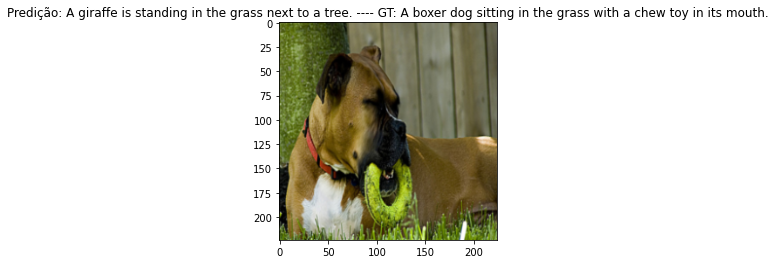

Época: 1/49 Train Loss: 2.825977  Valid Loss: 9.825253 / Train BLEU: 2.877827664813193 Valid BLEU: 6.158593505787174


  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

['A cat sitting on top of a wooden table with a stuffed animal.', 'A cat sitting on top of a laptop computer. a t', 'A man riding a horse in a field. a horse is standing in the grass.', 'A cat sitting on top of a laptop computer. a dog laying on top of a', 'A man is riding a horse in a field. a man is riding a horse', 'A man riding a horse in a field. a horse is standing in the grass.', 'A man riding a horse on a beach. a man riding a horse in the water.', 'A man is riding a horse in a field. a horse is standing in the grass.', 'A man and a dog are on the beach. a dog is sitting on the beach with', 'A giraffe standing next to a tree in a grassy field. giraffe standing next to', 'A giraffe standing next to a tree in a grassy field. a giraffe standing', 'A man riding a horse in a field. a dog is laying on the ground.', 'A man and a dog are sitting on a bench. a horse', 'A cat laying on top of a laptop computer. a cat laying on top of', 'A cat sitting on top of a laptop computer. a cat la

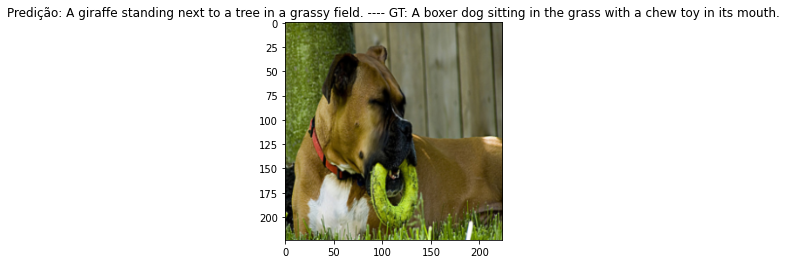

Época: 2/49 Train Loss: 2.737083  Valid Loss: 9.926634 / Train BLEU: 3.228733154968911 Valid BLEU: 6.791459320468737


  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

['A cat sitting on a table with a stuffed animal. a dog sitting on a wooden bench.', 'A man sitting on a bench with a dog on a leash. a man in a suit and tie is holding', 'A man is riding a horse on a dirt road. a man is riding a horse in a field.', 'A cat sitting on a laptop computer with a laptop. a cat sitting on a laptop computer.', 'A man is riding a horse on a dirt road. a man is riding a horse in a field.', 'A man is riding a horse on a dirt road. a man is riding a horse in a field.', 'A man is riding a horse on a dirt road. a man is riding a horse in a field.', 'A man is riding a horse on a dirt road. a man is riding a horse in a field.', 'A man in a blue shirt is riding a horse. a man in a blue shirt is riding a horse.', 'A giraffe standing next to a tree in a field. a giraffe standing next to a', 'A man in a hat holding a frisbee in his mouth. a dog in a field with a', 'A cat sitting on top of a laptop computer. a dog sitting on a bench near a tree.', 'A man is holding a hot 

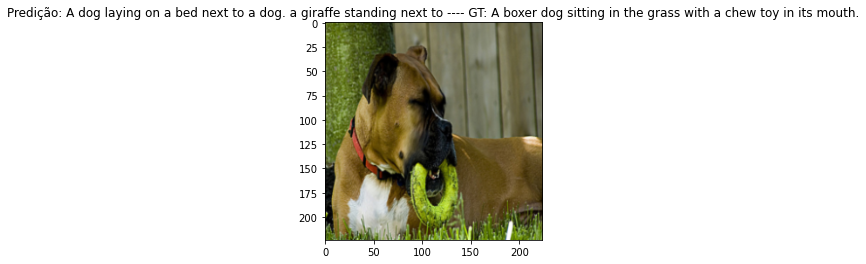

Época: 3/49 Train Loss: 2.677422  Valid Loss: 10.024640 / Train BLEU: 3.39916333497641 Valid BLEU: 5.966000545461796


  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

['A cat is sitting on a table with a stuffed animal.', 'A man riding a horse in a field. a man riding a horse in a field.', 'A man riding a horse in a field. a zebra standing in a field.', 'A cat is sitting on a couch with a laptop. a cat is sitting on a couch', 'A man is riding a horse on a street. a man is riding a', 'A red and white truck parked in a field. a zebra standing in the grass.', 'A man riding a horse in a field. a man riding a horse in a field.', 'A man riding a horse in a field. a zebra standing in front of', 'A man riding a horse on a beach. a dog is laying on a beach', 'A bird perched on a branch of a tree.', 'A giraffe is eating leaves from a tree. zebras are eating leaves from', 'A cat sitting on a couch with a laptop. a dog sitting on a couch.', 'A giraffe is eating leaves from a tree. a', 'A cat is sitting on a couch with a stuffed animal.', 'A cat is sitting on a couch with a stuffed animal. a cat is sitting', 'A cat is sitting on a chair with a laptop. a cat is s

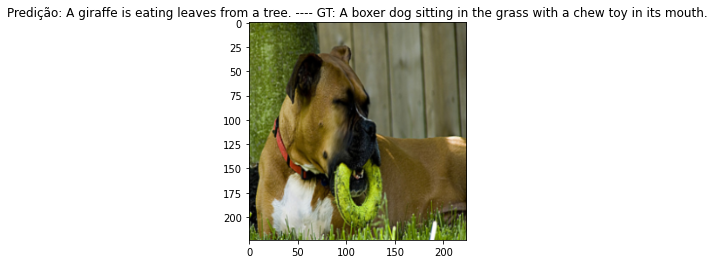

Época: 4/49 Train Loss: 2.631908  Valid Loss: 10.129394 / Train BLEU: 3.6019715660647096 Valid BLEU: 6.33057443705858


  0%|          | 0/940 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Treinamento
lr = config_wandb["learning_rate"]
compare=float('-inf')
n_epochs = config_wandb["epochs"]


model = CNNT5Model(tokenizer, config_wandb["decoder_pretrained_model"])
model = model.to(device)

#indices = torch.randperm(len(train_dataset))[:500]
#dataset_train = torch.utils.data.Subset(train_dataset, indices)
#train_loader = DataLoader(dataset_train, batch_size=5, shuffle=True, collate_fn = collate_custom, drop_last=True)

train_loader = DataLoader(train_dataset, batch_size=config_wandb["batch_size"], shuffle=True, collate_fn = collate_custom, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config_wandb["batch_size"], collate_fn = collate_custom, drop_last=True)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# referencia: https://towardsdatascience.com/machine-translation-evaluation-with-sacrebleu-and-bertscore-d7fdb0c47eb3
bleu = BLEU()

train_losses = []
val_losses = []
val_bleu_epoch = []
train_bleu_epoch = []

eval_epochs = 1

# Starting wandb
if run_id is not None:
    print(run_id)
    run = wandb.init(project="Image_Captioning", name=f"experiment_CNN_T5_{run}", config=config_wandb, resume=run_id, id=run_id, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

else:
    epoch_init = 0
    run = wandb.init(project="Image_Captioning", name=f"experiment_CNN_T5_{run}", config=config_wandb, resume=True, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

if wandb.run.resumed:
    print("Wandb --resumed")
    wandb.restore(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    checkpoint = torch.load(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    print(checkpoint['loss'])
    print(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch']+1
    loss = checkpoint['loss']

for epoch in  range(epoch_init, config_wandb["epochs"]):
    bleu_list = []
    for batch, (train_inputs, train_targets, train_all_targets) in enumerate(tqdm(train_loader)):
        model.train()
        model.zero_grad()

        train_inputs = train_inputs.to(device)
        train_targets = train_targets.to(device)

        # para o calculo da loss deve aplicar a máscara no start of sequence também? 
        mylabels = train_targets.clone()
        mylabels[mylabels==tokenizer.pad_token_id] = -100

        train_output = model(images = train_inputs, targets=mylabels)
        logits = train_output.logits
        loss = train_output.loss
        train_preds = torch.argmax(logits, dim=-1)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds_sentences = tokenizer.batch_decode(train_preds,  skip_special_tokens=True) #returns a list
        bleu_result = bleu.corpus_score(preds_sentences, list(zip(*train_all_targets)))
        bleu_list.append(bleu_result.score)
        
        wandb.log({"train/batch": batch,
                   "train/batch/loss":loss.item(), 
                   "train/batch/bleu_score":bleu_result.score, 
                   "train/batch/bleu_score_p1":bleu_result.precisions[0],
                   "train/batch/bleu_score_p4":bleu_result.precisions[3]})
    
    train_loss = sum(train_losses)/len(train_losses)
    train_bleu = sum(bleu_list)/len(bleu_list)
    

    with torch.no_grad():
        bleu_list = []
        for val_batch, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)

            model.eval()
    
            decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)

            val_labels = torch.cat([decoded_ids,val_targets[:,:-1]], dim=-1)

            for step in range(config_wandb["max_seq_length"]):
                output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
                #print(f"logits.shape: {output_val.logits.shape}")
                val_logits = output_val.logits
                next_token_logits = val_logits[:, -1, :]
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
                #print(f"decoded_ids batch: {decoded_ids}")

                # Check if output is end of senquence for all batches
                #if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
                #    break

            loss_v = nn.functional.cross_entropy(val_logits.contiguous().view(-1, val_logits.shape[-1]), val_labels.view(-1), reduction='mean', ignore_index=0)
            val_losses.append(loss_v)
            val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
            print(val_preds_sentences) 
            bleu_result = bleu.corpus_score(val_preds_sentences, list(zip(*val_all_targets)))
            bleu_list.append(bleu_result.score)

            wandb.log({"val/batch": val_batch, 
                    "val/batch/loss":loss_v,
                    "val/batch/bleu_score":bleu_result.score, 
                    "val/batch/bleu_score_p1":bleu_result.precisions[0],
                    "val/batch/bleu_score_p4":bleu_result.precisions[3]})
            
        val_loss = sum(val_losses)/len(val_losses)
        val_bleu = sum(bleu_list)/len(bleu_list)

        if val_bleu>compare:
                compare=val_bleu
                torch.save(model, config_wandb["path_save_model"])
    
    if epoch % config_wandb["eval_epochs"] == 0:
        plt.figure()
        plt.imshow(unorm(val_inputs[0].cpu()).permute(1,2,0))
        plt.title("Predição: "+str(val_preds_sentences[0] + " ---- GT: " +str(val_all_targets[0][0])))
        plt.show()
        plt.pause(0.05)

    wandb.log({"epoch": epoch, 
                "train/epoch/loss": train_loss,
                "train/epoch/bleu_score": train_bleu,
                "val/epoch/loss": val_loss, 
                "val/epoch/bleu_score": val_bleu})

    torch.save({ # Save our checkpoint loc
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    wandb.save() # saves checkpoint to wandb

    print(f'Época: {epoch:d}/{n_epochs - 1:d} Train Loss: {train_loss:.6f}  Valid Loss: {val_loss:.6f} / Train BLEU: {train_bleu} Valid BLEU: {val_bleu}')

In [ ]:
wandb.finish()

epoch,▁▃▅▆█
train/batch,▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
train/batch/bleu_score,▃▂▂▄▃▃▂▂▂▃▂▃▃▃▂▄▄▃▂▄▄▃▆▂▅▄▆▃▅▂▄▂▆█▁▅▄▄▄▂
train/batch/bleu_score_p1,▃▃▃█▅▄▅▂▂▃▃▄▅▄▄▅▁▁▅▄▃▂▅▄▄▄▃▄▅▃▄▂▅▅▂▄▃▄▃▃
train/batch/bleu_score_p4,▂▁▁▂▂▁▁▁▁▂▁▂▂▂▁▂▃▂▁▂▂▁▄▁▄▃▅▂▃▁▃▁▄█▁▄▃▂▃▁
train/batch/loss,█▇▅▄▄▃▄▃▄▄▂▄▃▄▄▂▅▄▄▂▃▃▂▂▃▂▃▂▁▂▃▂▄▂▃▃▂▃▃▂
train/epoch/bleu_score,▁▄▆▇█
train/epoch/loss,█▅▃▂▁
val/batch,▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
val/batch/bleu_score,▆▂▄▆▅▄▅▅▅▂▃▃▃▂▃▂█▃▁▅▃▅▇▄▃▃▄▆▁▄▄▆▂▂▃▇▃▂▂▄
val/batch/bleu_score_p1,▅▃▃▆▄▃▄▅▅█▆▇█▆▆▆▆▄▄▆▄▄▅▄▁▁▂▃▂▁▃▁▅▆▃▅▅▅▇▅


In [ ]:
for val_batch, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
    val_inputs = val_inputs.to(device)
    val_targets = val_targets.to(device)

    model.eval()
    
    decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)

    val_labels = torch.cat([decoded_ids,val_targets[:,:-1]], dim=-1)

    for step in range(config_wandb["max_seq_length"]):
        output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
        #print(f"logits.shape: {output_val.logits.shape}")
        val_logits = output_val.logits
        next_token_logits = val_logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
        #print(f"decoded_ids batch: {decoded_ids}")

        # Check if output is end of senquence for all batches
        if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
            break

    loss_v = nn.functional.cross_entropy(val_logits.contiguous().view(-1, val_logits.shape[-1]), val_labels.view(-1), reduction='mean', ignore_index=0)
    val_losses.append(loss_v)
    val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
    print(val_preds_sentences) 
    bleu_result = bleu.corpus_score(val_preds_sentences, list(zip(*val_all_targets)))
    bleu_list.append(bleu_result.score)


  0%|          | 0/35 [00:00<?, ?it/s]

['A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A large jet airplane flying over a blue sky.', 'A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A man and a dog are standing on a beach.', 'A man and a dog are standing on a boat.', 'A man and a dog are sitting on a bench.', 'A large jet airplane flying over a blue sky.', 'A bird is standing on a tree branch.', 'A dog is standing on a bench next to a tree.', 'A large jet flying over a blue sky.', 'A cat laying on a bed with a stuffed animal.', 'A cat laying on a bed with a stuffed animal.', 'A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A cat sitting on a laptop computer.', 'A man and a dog are standing on a beach.', 'A man riding a horse in a field.', 'A cat sitting on a laptop computer.', 'A

RuntimeError: ignored

In [ ]:
val_logits.shape

torch.Size([30, 16, 32128])

In [ ]:
val_labels.shape

torch.Size([30, 32])

# Backup